In [ ]:
# Set seeds
from numpy.random import seed
import tensorflow as tf
seed(42)
tf.random.set_seed(42)

In [ ]:
# Upgrade module imbalanced-learn to run on Google Colab
#!pip install imbalanced-learn --upgrade

# Import modules
import imblearn
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sklearn

from google.colab import drive
from imblearn.over_sampling import RandomOverSampler
from keras.applications.resnet import ResNet50
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, History
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.models import Sequential,Model,load_model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from platform import python_version
from sklearn.model_selection import train_test_split

%matplotlib inline

# Versions
print("Version Python:",python_version())
print()
print("Version Imbalanced-learn:",imblearn.__version__)
print("Version Keras:",keras.__version__)
print("Version Matplotlib:",matplotlib.__version__)
print("Version NumPy:",np.__version__)
print("Version Pandas:",pd.__version__)
print("Version Scikit-learn:",sklearn.__version__)
print("Version TensorFlow:",tf.__version__)

In [ ]:
# Set data folder and load dataframe
drive.mount('/content/drive')
data_folder = '/content/drive/MyDrive/'
data = pd.read_pickle(os.path.join(data_folder, 'data.pkl'))
data = data[data["loc_group"] == 'No Sun']

In [ ]:
data.dx.value_counts()

nv       4048
mel       533
bkl       394
bcc       266
vasc       86
akiec      47
df          9
Name: dx, dtype: int64

In [ ]:
# Setting data augmentation parameters 
data_augmentation = ImageDataGenerator(
    rotation_range = 60,
    zoom_range = 0.2,  
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,  
    vertical_flip = True,  
    shear_range = 10) 

In [ ]:
# Create training, validation amd test sets (Derived from: https://www.kaggle.com/kaimingk/skin-cancer-mnist-ham10000)

# Split 70%, 10%, 20%. Test and validation, together 30%, should be from unique ID's only
size_val_test = 0.3 * len(data)
val_test_ratio_from_unique = size_val_test/len(data[data.unique == True])

# Training data = remainder of unique ID's + non-uniques. Split is stratified by lesion 
bm_data_train_unique, bm_data_val_test = train_test_split(data[data["unique"] == True], test_size = val_test_ratio_from_unique, stratify=data[data["unique"] == True]["dx_cat"], random_state = 42)
bm_data_train = pd.concat((bm_data_train_unique, data[data["unique"] == False]), axis = 0)

# Split validation and test sets. Split is stratified by lesion 
bm_data_validation, bm_data_test = train_test_split(bm_data_val_test, test_size = 0.6667, stratify=bm_data_val_test["lesion_type_cat"], random_state = 1)

print("Training set:   ", round(len(bm_data_train) / len(data)*100,1),"%")
print("Validation set: ", round(len(bm_data_validation) / len(data)*100,1),"%")
print("Testing set:    ", round(len(bm_data_test) / len(data)*100,1),"%")
print()

# Class balancing (random oversampling)
X = bm_data_train.drop(['dx_cat'], axis=1)
y = bm_data_train['dx_cat']
X_test = bm_data_test.drop(['dx_cat'], axis=1)
y_test = bm_data_test['dx_cat']

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
ros = RandomOverSampler(random_state=42)
X_test_resampled, y_test_resampled = ros.fit_resample(X_test, y_test)

bm_data_train = pd.concat([X_resampled, y_resampled], axis=1)
bm_data_test = pd.concat([X_test_resampled, y_test_resampled], axis=1)
print('Value counts in training set:')
print(bm_data_train['dx_cat'].value_counts())
print()
print('Value counts in testing set:')
print(bm_data_test['dx_cat'].value_counts())

# Create feature (x) and target (y) variables (for training, validation and test sets)
bm_data_train_x = np.asarray(bm_data_train['image'].tolist())
bm_data_validation_x = np.asarray(bm_data_validation['image'].tolist())
bm_data_test_x = np.asarray(bm_data_test['image'].tolist())

bm_data_train_y = np.asarray(bm_data_train['dx_cat'].tolist())
bm_data_validation_y = np.asarray(bm_data_validation['dx_cat'].tolist())
bm_data_test_y = np.asarray(bm_data_test['dx_cat'].tolist())

# One-hot encoding of target variable
bm_num_classes = len(np.sort(data['dx'].unique()))
bm_data_train_y = to_categorical(bm_data_train_y, num_classes = bm_num_classes)
bm_data_validation_y = to_categorical(bm_data_validation_y, num_classes = bm_num_classes)
bm_data_test_y = to_categorical(bm_data_test_y, num_classes = bm_num_classes)

Training set:    70.0 %
Validation set:  10.0 %
Testing set:     20.0 %

Value counts in training set:
6    2664
5    2664
4    2664
3    2664
2    2664
1    2664
0    2664
Name: dx_cat, dtype: int64

Value counts in testing set:
6    918
2    918
5    918
1    918
4    918
0    918
Name: dx_cat, dtype: int64


In [ ]:
# Fit data augmentation
data_augmentation.fit(bm_data_train_x)

In [ ]:
# Creating ResNet model (Derived from: https://www.kaggle.com/jnegrini/ham10000-analysis-and-model-comparison)

# Model parameters
input_shape = (75, 100, 3)
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
epochs = 50
batch_size = 32

# Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=20,monitor='val_accuracy')
history = History()

# Define model architecture
base_model = ResNet50(include_top=False, input_shape=(75,100, 3),pooling = 'avg', weights = 'imagenet');

ResNet50model_multi = Sequential()
ResNet50model_multi.add(base_model)
ResNet50model_multi.add(Dropout(0.2))
ResNet50model_multi.add(Dense(128, activation="relu"))
ResNet50model_multi.add(Dropout(0.2))
ResNet50model_multi.add(Dense(bm_num_classes, activation = 'softmax'))
ResNet50model_multi.summary()

# Layers in ResNet are pretrained (ImageNet)
for layer in base_model.layers:
    layer.trainable = False
    
ResNet50model_multi.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=['accuracy'])

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 23,850,887
Trainable params: 23,797,767
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
# Fit and save model
bm_history = ResNet50model_multi.fit(data_augmentation.flow(bm_data_train_x,bm_data_train_y, batch_size=batch_size),
                        epochs = epochs, validation_data = (bm_data_validation_x,bm_data_validation_y),
                        verbose = 1, steps_per_epoch=bm_data_train_x.shape[0] // batch_size, 
                        callbacks=[learning_rate_reduction,early_stopping_monitor, history])

ResNet50model_multi.save(os.path.join(data_folder,"Loc_No_Sun_multi_model"))

Epoch 1/50
582/582 [==============================] - 97s 75ms/step - loss: 1.3432 - accuracy: 0.4962 - val_loss: 0.7633 - val_accuracy: 0.7082
Epoch 2/50
582/582 [==============================] - 38s 66ms/step - loss: 0.8648 - accuracy: 0.6741 - val_loss: 0.5828 - val_accuracy: 0.7900
Epoch 3/50
582/582 [==============================] - 38s 66ms/step - loss: 0.7630 - accuracy: 0.7078 - val_loss: 0.7682 - val_accuracy: 0.7045
Epoch 4/50
582/582 [==============================] - 38s 65ms/step - loss: 0.7079 - accuracy: 0.7277 - val_loss: 0.6331 - val_accuracy: 0.7732
Epoch 5/50
582/582 [==============================] - 38s 65ms/step - loss: 0.6822 - accuracy: 0.7331 - val_loss: 0.6875 - val_accuracy: 0.7509
Epoch 6/50
582/582 [==============================] - 38s 66ms/step - loss: 0.6483 - accuracy: 0.7520 - val_loss: 0.5830 - val_accuracy: 0.7751
Epoch 7/50
582/582 [==============================] - 38s 64ms/step - loss: 0.6346 - accuracy: 0.7598 - val_loss: 0.6477 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Loc_No_Sun_multi_model/assets


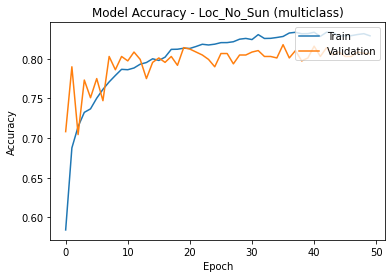

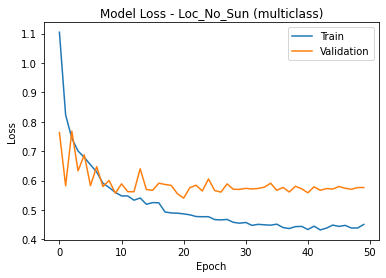

In [ ]:
# Accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy - Loc_No_Sun (multiclass)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
filename = str('Model Accuracy - Loc_No_Sun (multiclass).png')
plt.savefig(os.path.join(data_folder,filename), dpi=600)
plt.show()

# Loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss - Loc_No_Sun (multiclass)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
filename = str('Model Loss - Loc_No_Sun (multiclass).png')
plt.savefig(os.path.join(data_folder,filename), dpi=600)
plt.show()

In [ ]:
with open(os.path.join(data_folder, 'data_bm_loc_no_sun.pkl'), 'wb') as f:
    pickle.dump([bm_data_train_x,bm_data_validation_x,bm_data_test_x,bm_data_train_y,bm_data_validation_y,bm_data_test_y], f)